# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [4]:
def plot_distribution(df, column, color, row, axes):
    """
    Визуализация распределения и ящика с усами для указанного столбца.

    :param df: DataFrame, содержащий данные.
    :param column: Название столбца для визуализации.
    :param color: Цвет для графиков.
    :param row: Индекс строки в сетке графиков.
    :param axes: Массив осей для рисования графиков.
    """
    # Гистограмма
    histplot = sns.histplot(data=df, x=column, color=color, ax=axes[row][0])
    histplot.set_title(f'Распределение {column}')
    histplot.axvline(df[column].mean(), color='k', lw=2)  # Среднее значение
    histplot.axvline(df[column].mean() + 3 * df[column].std(), color='k', ls='--', lw=2)  # +3sigma
    histplot.axvline(df[column].mean() - 3 * df[column].std(), color='k', ls='--', lw=2)  # -3sigma

    # Ящик с усами
    boxplot = sns.boxplot(data=df, x=column, color=color, ax=axes[row][1])
    boxplot.set_title(f'Распределение {column}')

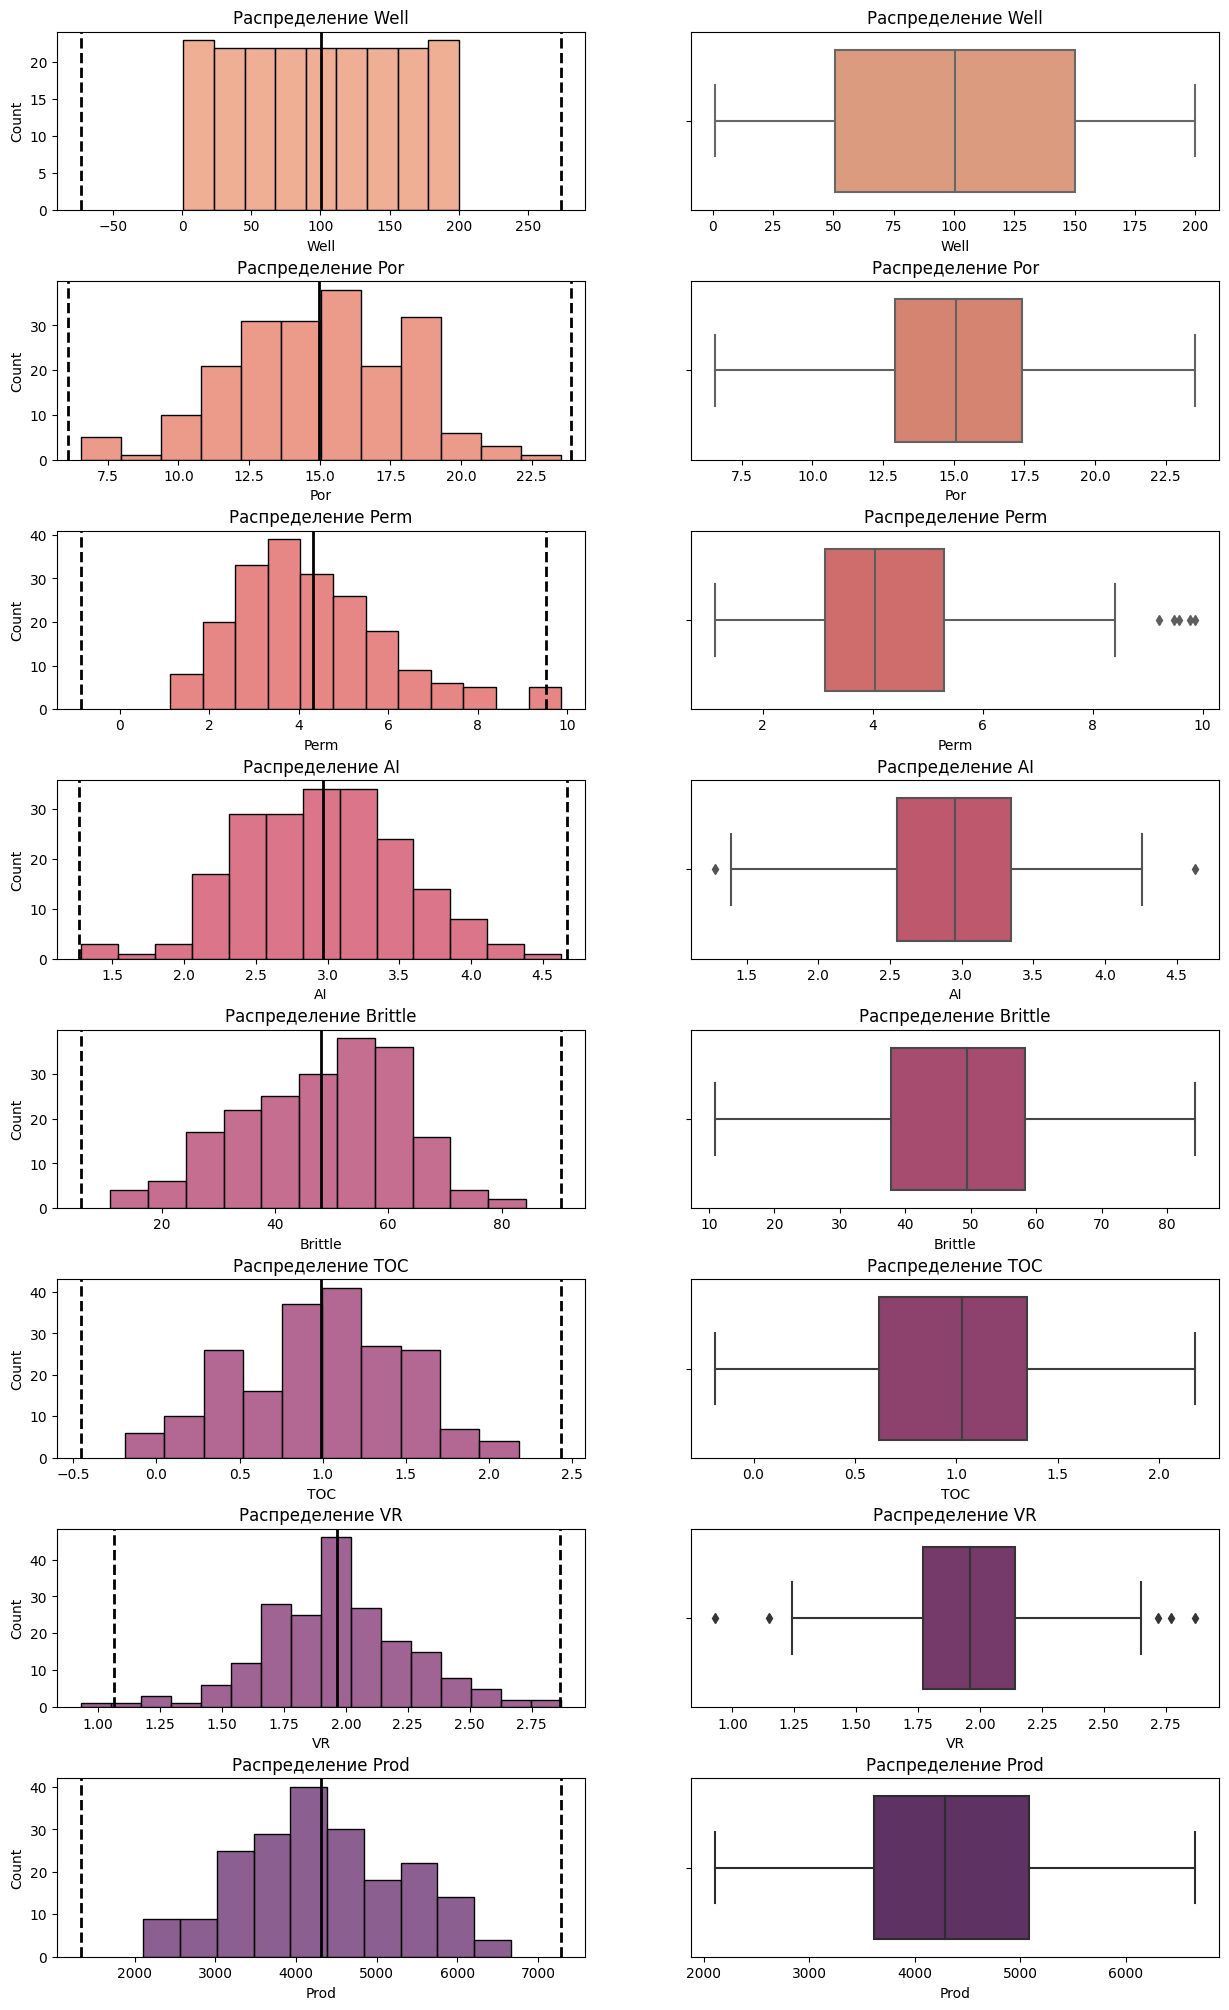

In [13]:
# Прописываем параметры для функции
colors = sns.color_palette('flare', n_colors=8)
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 25))
plt.subplots_adjust(hspace=0.4)

columns_to_plot = ['Well', 'Por',  'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']

# используем цикл для формирования диаграмм
for i, column in enumerate(columns_to_plot):
    plot_distribution(data, column, colors[i], i, axes)

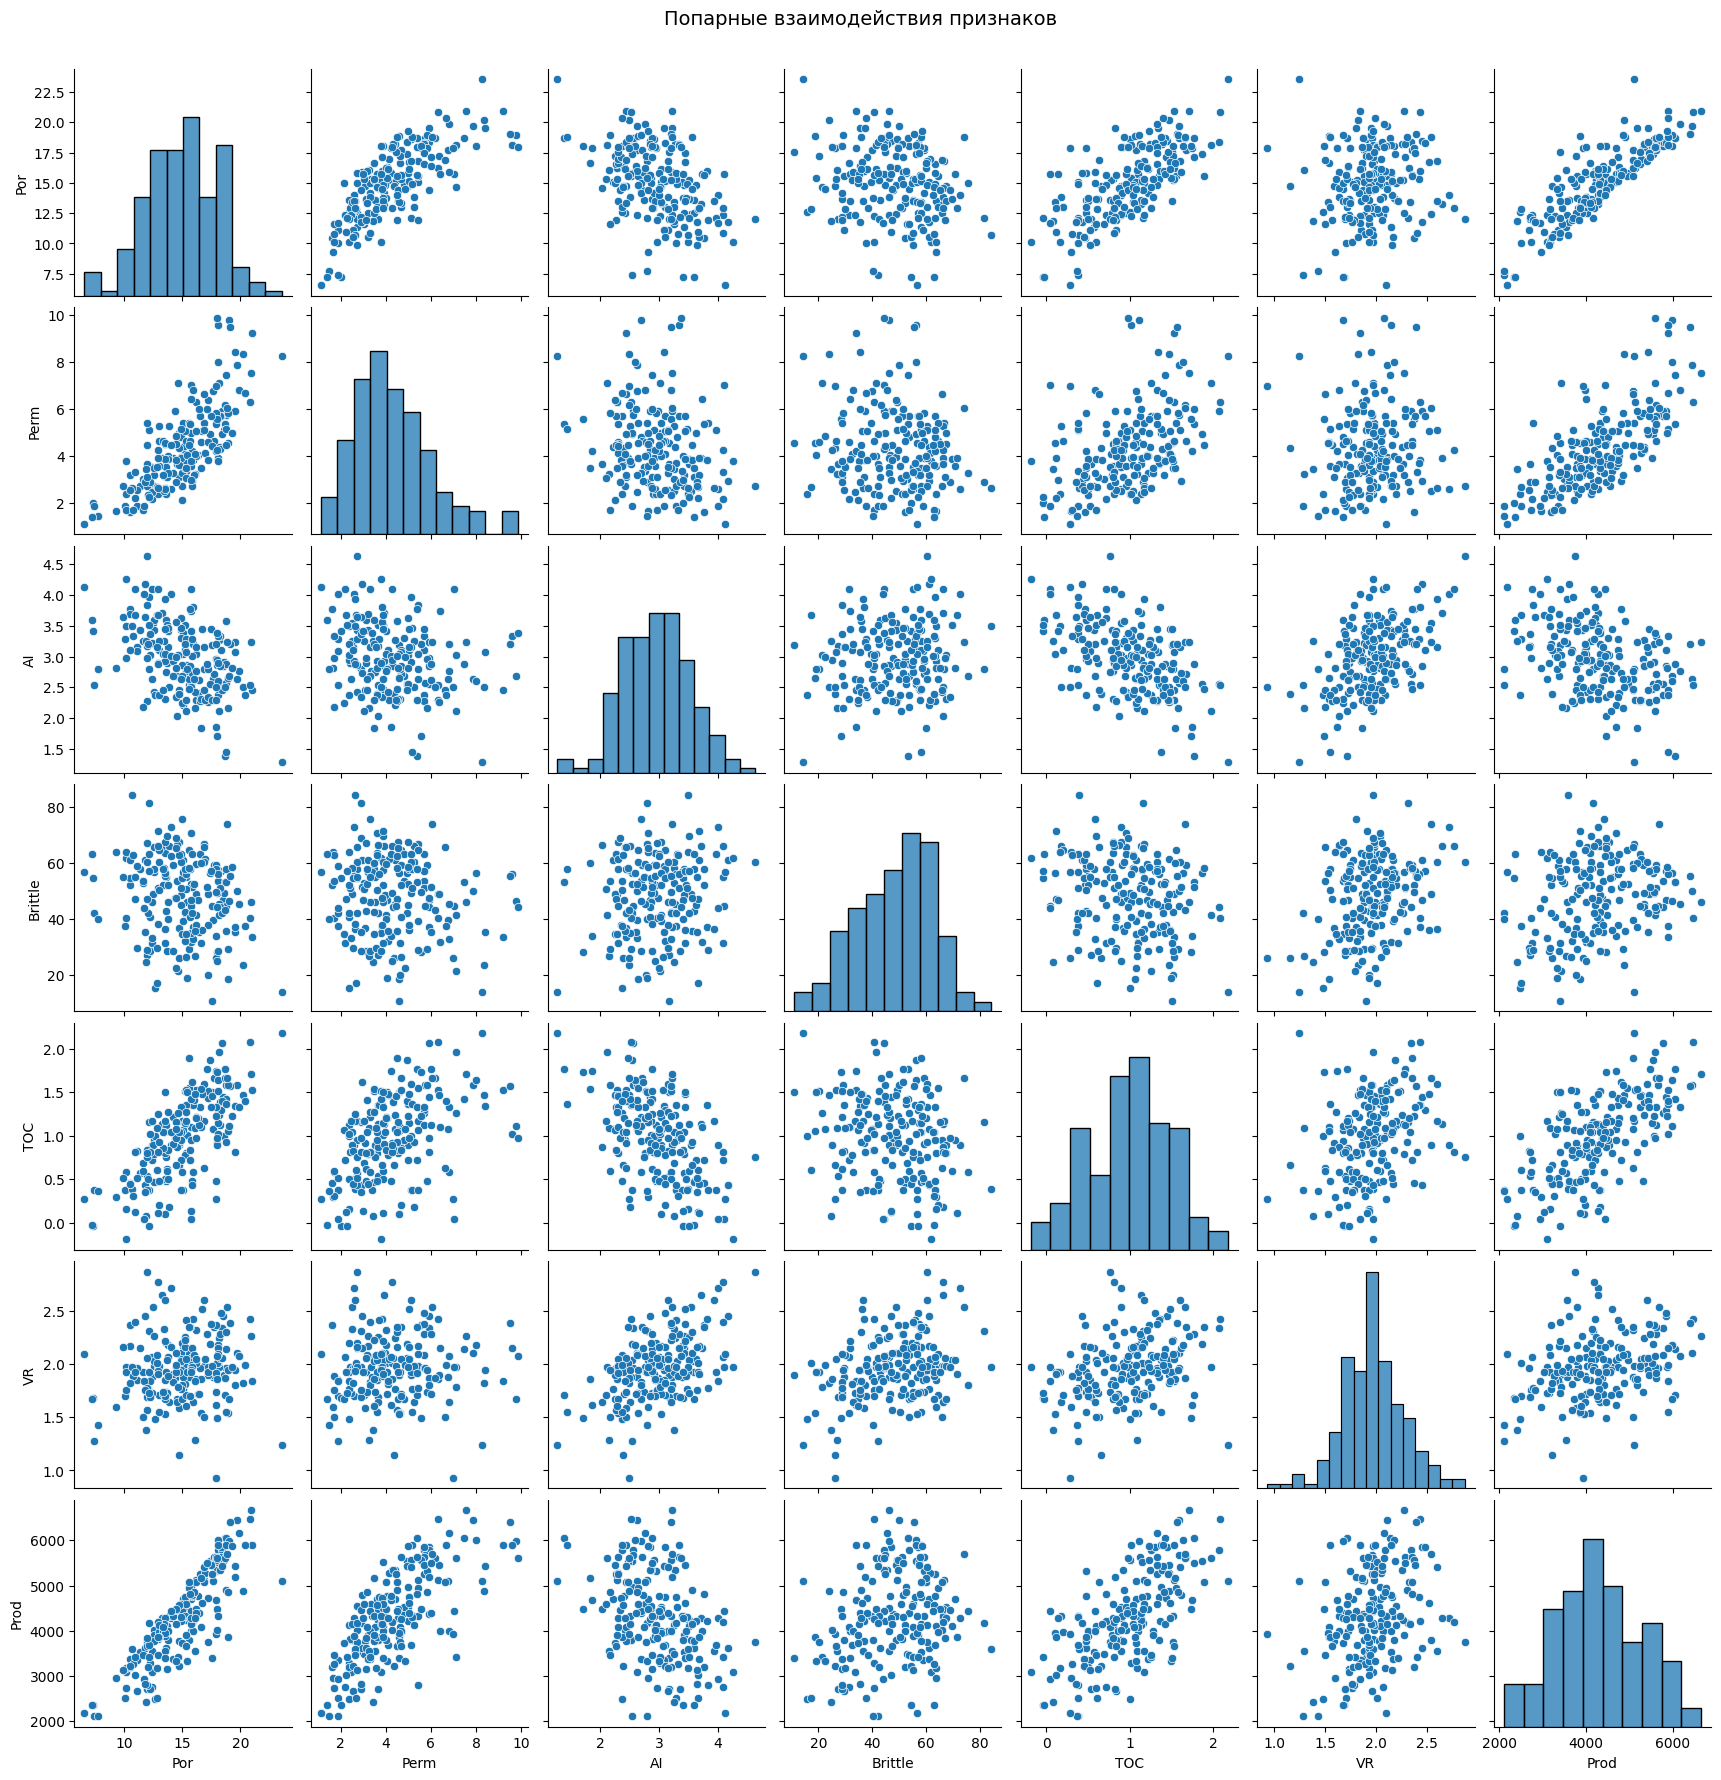

In [12]:
# Подготовка данных для графика попарных взаимодействий
df2 = data[['Por',  'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']]

# Создание графика попарных взаимодействий
pairplot = sns.pairplot(df2)

# Добавление заголовка к графику
plt.suptitle('Попарные взаимодействия признаков', 
             size=14, y=1.02)

# Отображение графика
plt.show()

> В данных отсутствуют пропуски; признаки распределены нормально, кроме Perm — проницаемости скважины, распределение данного признака больше похоже на лог-нормальное. 

> Наблюдается зависимость целевого признака Prod — добыча газа в сутки с Por — пористостью скважины, Рerm — проницаемостью скважины и не столь ярко выраженная с TOC — общим органическим углеродом. Кроме того наблюдается зависимость Por — пористости скважины с TOC — общим органическим углеродом и с Perm — проницаемостью скважины. 

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

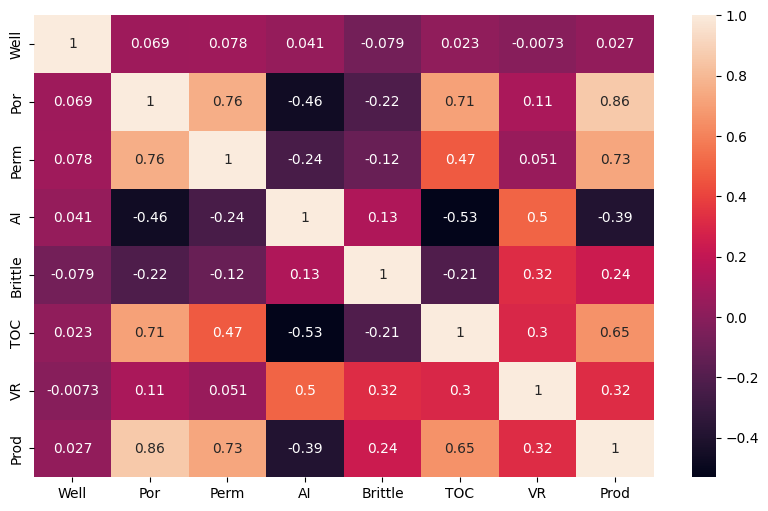

In [23]:
# Создаем копию исходного DataFrame для проведения анализа корреляций
df_corr = data.copy()

# Устанавливаем размер фигуры для тепловой карты
fig = plt.figure(figsize=(10, 6))

# Вычисляем корреляционную матрицу
corr = df_corr.corr()

# Создаем тепловую карту для визуализации корреляционной матрицы
# `annot=True` позволяет отобразить числовые значения внутри ячеек карты
sns.heatmap(corr, annot=True)

# Отображаем график
plt.show()

In [24]:
# Ранг матрицы корреляций
print(f'Ранг матрицы: {np.linalg.matrix_rank(corr)}')

# Определитель матрицы корреляций
print(f'Определитель матрицы: {np.linalg.det(corr)}')

Ранг матрицы: 8
Определитель матрицы: 0.0007299388072652095


> С целевой переменной Prod сильнее всего коррелирует признак Por - наблюдается сильная положительная связь, затем Perm также сильная полодительная связь, а также принак TOC - средняя положительная связь. Выводы сделанные из матрицы корреляций, совпадают с выводами сделанными на основе графиков.

> Полученная матрица явялется плохо обусловленной, поскольку ее определитель близок к нулю. Поскольку ранг матрицы равен количеству столбцов можно утверждать, что все вектора признаки линейно независимы, что логично поскольку в матрице отсутствуют единицы кроме как на главной диагонали. В данной матрице отсутсвует чистая коллинеарность, поскольку единицы наодятся лишь на главной диагонали и ранг матрицы совпадает с числом признаков, но можно говорить о случае мультиколлинеарности, поскольку определитель стремится к нулю.

> Модель классической линейной регрессии по методу наименьших квадратов бе сингулярного разложения в данном случае лучше не применять, поскольку матрица корреляций близка к вырожденной.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [33]:
# Составляем матрицу X
data_x = data[['Well', 'Por',  'Perm', 'AI', 'Brittle', 'TOC', 'VR']]
X = data_x.values

# Добывляем столбец единиц
X = np.column_stack((np.ones(200), X))

# Составляем вектор целевой переменной y
y = data[['Prod']]

print(f'Размерность матрицы наблюдений X: {X.shape}')
print(X)

Размерность матрицы наблюдений X: (200, 8)
[[ 1.000e+00  1.000e+00  1.208e+01 ...  8.140e+01  1.160e+00  2.310e+00]
 [ 1.000e+00  2.000e+00  1.238e+01 ...  4.617e+01  8.900e-01  1.880e+00]
 [ 1.000e+00  3.000e+00  1.402e+01 ...  7.280e+01  8.900e-01  2.720e+00]
 ...
 [ 1.000e+00  1.980e+02  1.212e+01 ...  5.707e+01 -4.000e-02  1.730e+00]
 [ 1.000e+00  1.990e+02  1.555e+01 ...  5.825e+01  1.890e+00  2.350e+00]
 [ 1.000e+00  2.000e+02  2.089e+01 ...  4.617e+01  1.710e+00  2.270e+00]]


In [39]:
# вычислим OLS-оценку для коэффициентов с округлением до целого
w_hat = round(np.linalg.inv(X.T@X)@X.T@y, 0)
print(w_hat.values)

[[-1232.]
 [    0.]
 [  230.]
 [  116.]
 [ -365.]
 [   25.]
 [  -78.]
 [  785.]]


> В данном случае принак Well не оказывает никакого влияния на целевую переменную. При увеличении пористости скважины (Por) на 1% добыча газа в сутки (Prod) увеличится на 230 млн. кубических футов, а при увеличении акустического импеданса (AI) на 1 $кг/м^2 * 10^6$, добыча газа в сутки (Prod) уменьшится на 365 млн. кубических футов. Однако мы не можем говорить о важности влияния того или иного признака на целевую переменную, поскольку не была проведена стандартиация признаков.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [94]:
# Создаем датафрейм с новыми данными и добавляем столбец единицу в начало
data_new = pd.DataFrame({
    '1': [1],
    'Well': [106.0],
    'Por': [15.32],
    'Perm': [3.71],
    'AI': [3.29],
    'Brittle': [55.99],
    'TOC': [1.35],
    'VR': [2.42]
})

# делаем прогноз 
Prod_new = (data_new.values@w_hat).values
print('Предсказание: ', Prod_new)
print('Абсолютная ошибка прогноза:', 4748.315024 - Prod_new)

Предсказание:  [[4723.06405371]]
Абсолютная ошибка прогноза: [[25.25097029]]


> *Ваши выводы здесь*

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [98]:
from sklearn.linear_model import LinearRegression
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)
# вычисляем коэффициенты регрессии
model.fit(X, y)
print('w_hat:', model.coef_.round())
new_prediction = model.predict(data_new.values)
print('prediction:', new_prediction)

w_hat: [[-1232.     0.   230.   116.  -365.    25.   -78.   785.]]
prediction: [[4723.06405371]]


> *Ваши выводы здесь*

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*